In [1]:
from config import *

from easyric.caas_lite import TiffSpliter
from easyric.objects import Pix4D
from easyric.io import shp, geotiff, plot
from easyric.calculate import geo2raw, geo2tiff

import os
import shapefile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import tifffile



In [2]:
import re
import pickle
import json
from scipy.spatial import KDTree
from easyric import caas_lite
import tifffile as tf
from skimage.transform import ProjectiveTransform
import random
from tqdm.notebook import tqdm

# data io

In [3]:
# read field measure data
destructive = pd.read_csv("out/destructive.csv")
destructive

,date,pos,field,0,90,45,135,weight_g
0,20210514,West,17-100,96,107,102,109,240
1,20210514,West,17-101,75,74,69,71,190
2,20210514,West,17-102,76,81,72,82,230
3,20210514,West,17-103,73,82,80,79,200
4,20210514,West,17-104,109,109,110,107,275
...,...,...,...,...,...,...,...,...
553,20210520,West,23-69,113,100,100,111,230
554,20210520,West,23-7,142,140,151,140,460
555,20210520,West,23-70,139,131,140,137,320
556,20210520,West,23-8,149,135,137,143,400


In [4]:
pd.unique(destructive.date)

array([20210514, 20210517, 20210519, 20210520])

In [5]:
# read uav data
uav_measured = pd.read_excel("out/2021_measured_fix.xlsx")
uav_measured

,date,field,label,pos,area(mm2),convex_area(mm2),eccentricity,equivalent_diameter(mm),major_axis_length(mm),minor_axis_length(mm),perimeter(mm),circularity
0,20210512,24-2,285,West,2371,2529,0.485232,54.944071,59.213990,51.775862,197.438600,0.764324
1,20210514,24-2,285,West,4424,4565,0.438728,75.052060,79.395531,71.346405,260.350288,0.820179
2,20210515,24-2,285,West,5680,5766,0.314625,85.041170,87.950560,83.484087,291.521861,0.839877
3,20210519,24-2,285,West,12854,13470,0.500925,127.930532,139.130930,120.416505,460.315801,0.762318
4,20210520,24-2,285,West,14110,14488,0.489623,134.035107,144.629077,126.107069,460.658946,0.835560
...,...,...,...,...,...,...,...,...,...,...,...,...
17697,20210526,15-125,1660,West,4380,4698,0.611704,74.677903,84.545288,66.882632,284.971609,0.677768
17698,20210526,12-66,2015,East,4128,4778,0.895483,72.497813,117.143445,52.140058,314.699531,0.523790
17699,20210526,4-21,3082,East,9414,10683,0.893977,109.481857,170.052081,76.202503,446.931024,0.592247
17700,20210526,1-33,3513,East,4057,5397,0.942323,71.871641,137.165555,45.910162,340.693434,0.439225


In [6]:
pd.unique(uav_measured.date)

array([20210512, 20210514, 20210515, 20210519, 20210520, 20210526])

In [7]:
# merge to training data
merged_pd = pd.merge(destructive[["date", "field", "weight_g"]], uav_measured, left_on=["date", "field"], right_on=["date","field"])
merged_pd

,date,field,weight_g,label,pos,area(mm2),convex_area(mm2),eccentricity,equivalent_diameter(mm),major_axis_length(mm),minor_axis_length(mm),perimeter(mm),circularity
0,20210514,17-100,240,1356,West,7279,7435,0.191766,96.269988,97.657230,95.844782,329.948268,0.840214
1,20210514,17-101,190,1357,West,2497,2566,0.762258,56.385097,71.716300,46.420005,204.651804,0.749199
2,20210514,17-102,230,1358,West,3684,3755,0.625595,68.488061,78.072315,60.907938,235.379726,0.835586
3,20210514,17-103,200,1359,West,4197,4644,0.832301,73.101206,103.168990,57.189104,283.906638,0.654331
4,20210514,17-104,275,1360,West,7743,7864,0.579833,99.290955,110.782216,90.258180,341.320851,0.835206
...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,20210520,23-69,230,490,West,7755,7995,0.555752,99.367865,109.707366,91.205010,344.575685,0.820772
405,20210520,23-7,460,429,West,7664,11172,0.875705,98.783136,171.993129,83.046288,469.629509,0.436671
406,20210520,23-70,320,491,West,14070,14621,0.405839,133.844986,141.216903,129.064446,464.801082,0.818408
407,20210520,23-8,400,430,West,13929,14169,0.364512,133.172646,138.401759,128.879529,455.872150,0.842255


In [8]:
pd.unique(merged_pd.date)

array([20210514, 20210519, 20210520])

# auto sklearn

## test offical example

In [9]:
import autosklearn
import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

In [10]:
X, y = sklearn.datasets.load_diabetes(return_X_y=True)

X_train, X_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(X, y, random_state=1)

In [11]:
X.shape

(442, 10)

In [12]:
X_train.shape

(331, 10)

In [14]:
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    tmp_folder='/tmp/autosklearn_regression_example_tmp',
)
automl.fit(X_train, y_train, dataset_name='diabetes')

AutoSklearnRegressor(per_run_time_limit=30, time_left_for_this_task=120,
                     tmp_folder='/tmp/autosklearn_regression_example_tmp')

In [15]:
train_predictions = automl.predict(X_train)
print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))
test_predictions = automl.predict(X_test)
print("Test R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))

Train R2 score: 0.5990481774739435
Test R2 score: 0.4112276314587324


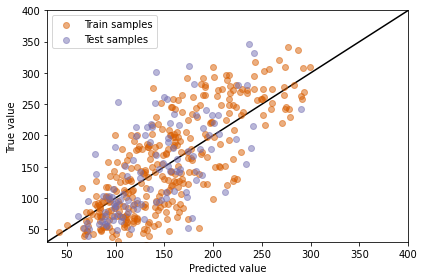

In [17]:
plt.scatter(train_predictions, y_train, label="Train samples", c='#d95f02', alpha=0.5)
plt.scatter(test_predictions, y_test, label="Test samples", c='#7570b3', alpha=0.5)
plt.xlabel("Predicted value")
plt.ylabel("True value")
plt.legend()
plt.plot([30, 400], [30, 400], c='k', zorder=0)
plt.xlim([30, 400])
plt.ylim([30, 400])
plt.tight_layout()
plt.show()

## use broccoli data

In [19]:
dataset = merged_pd.copy().drop(columns=["date", "field", "label", "pos"])
dataset

,weight_g,area(mm2),convex_area(mm2),eccentricity,equivalent_diameter(mm),major_axis_length(mm),minor_axis_length(mm),perimeter(mm),circularity
0,240,7279,7435,0.191766,96.269988,97.657230,95.844782,329.948268,0.840214
1,190,2497,2566,0.762258,56.385097,71.716300,46.420005,204.651804,0.749199
2,230,3684,3755,0.625595,68.488061,78.072315,60.907938,235.379726,0.835586
3,200,4197,4644,0.832301,73.101206,103.168990,57.189104,283.906638,0.654331
4,275,7743,7864,0.579833,99.290955,110.782216,90.258180,341.320851,0.835206
...,...,...,...,...,...,...,...,...,...
404,230,7755,7995,0.555752,99.367865,109.707366,91.205010,344.575685,0.820772
405,460,7664,11172,0.875705,98.783136,171.993129,83.046288,469.629509,0.436671
406,320,14070,14621,0.405839,133.844986,141.216903,129.064446,464.801082,0.818408
407,400,13929,14169,0.364512,133.172646,138.401759,128.879529,455.872150,0.842255


In [21]:
y = dataset.weight_g.to_numpy(dtype=int)
y

array([240, 190, 230, 200, 275, 210, 210, 200, 230, 220, 220, 205, 225,
       250, 265, 255, 275, 205, 185, 270, 180, 260, 195, 170, 215, 190,
       220, 265, 160, 235, 215, 205, 190, 215, 190, 240, 220, 205, 140,
       160, 190, 215, 215, 190, 195, 220, 175, 170, 175, 180, 250, 200,
       240, 190, 205, 195, 160, 145, 170, 190, 215, 190, 210, 205, 170,
       210, 190, 215, 245, 355, 280, 290, 320, 395, 330, 265, 265, 295,
       300, 390, 170, 240, 260, 240, 360, 275, 375, 260, 355, 295, 290,
       300, 260, 265, 215, 460, 320, 365, 260, 345, 305, 340, 265, 245,
       230, 205, 220, 285, 215, 185, 240, 390, 250, 335, 275, 190, 230,
       330, 270, 305, 280, 345, 175, 330, 280, 200, 320, 260, 300, 255,
       300, 355, 245, 210, 350, 410, 485, 460, 420, 355, 350, 380, 460,
       490, 410, 470, 370, 310, 420, 450, 380, 465, 440, 420, 380, 490,
       490, 450, 435, 245, 390, 460, 505, 450, 440, 445, 410, 250, 480,
       420, 545, 530, 490, 380, 210, 250, 280, 260, 420, 375, 36

In [23]:
X = dataset.copy().drop(columns=["weight_g"]).to_numpy()
X

array([[7.27900000e+03, 7.43500000e+03, 1.91765741e-01, ...,
        9.58447824e+01, 3.29948268e+02, 8.40213929e-01],
       [2.49700000e+03, 2.56600000e+03, 7.62258494e-01, ...,
        4.64200050e+01, 2.04651804e+02, 7.49199111e-01],
       [3.68400000e+03, 3.75500000e+03, 6.25595360e-01, ...,
        6.09079377e+01, 2.35379726e+02, 8.35586435e-01],
       ...,
       [1.40700000e+04, 1.46210000e+04, 4.05838649e-01, ...,
        1.29064446e+02, 4.64801082e+02, 8.18407689e-01],
       [1.39290000e+04, 1.41690000e+04, 3.64512150e-01, ...,
        1.28879529e+02, 4.55872150e+02, 8.42255160e-01],
       [9.57700000e+03, 1.20330000e+04, 8.03587318e-01, ...,
        9.44107661e+01, 4.78244733e+02, 5.26185602e-01]])

In [24]:
X.shape

(409, 8)

In [25]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=1)

In [26]:
X_train.shape

(306, 8)

In [29]:
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    tmp_folder='/tmp/autosklearn_regression_broccoli_tmp',
)

In [30]:
automl.fit(X_train, y_train, dataset_name='broccoli')

AutoSklearnRegressor(per_run_time_limit=30, time_left_for_this_task=120,
                     tmp_folder='/tmp/autosklearn_regression_broccoli_tmp')

In [55]:
print(automl.leaderboard())

          rank  ensemble_weight               type      cost  duration
model_id                                                              
3            1             0.02   gaussian_process  0.137534  2.735245
5            2             0.34  gradient_boosting  0.141484  0.665787
15           3             0.32                sgd  0.143862  0.426657
29           4             0.08  gradient_boosting  0.150881  0.866541
47           5             0.10      liblinear_svr  0.161731  0.459413
6            6             0.04   gaussian_process  0.228545  2.360277
33           7             0.04                mlp  0.285134  0.627641
28           8             0.06      liblinear_svr  0.309157  0.407578


In [56]:
print(automl.show_models())

[(0.340000, SimpleRegressionPipeline({'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense', 'data_preprocessing:numerical_transformer:imputation:strategy': 'median', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'none', 'feature_preprocessor:__choice__': 'polynomial', 'regressor:__choice__': 'gradient_boosting', 'feature_preprocessor:polynomial:degree': 2, 'feature_preprocessor:polynomial:include_bias': 'False', 'feature_preprocessor:polynomial:interaction_only': 'True', 'regressor:gradient_boosting:early_stop': 'valid', 'regressor:gradient_boosting:l2_regularization': 0.0018018055158809108, 'regressor:gradient_boosting:learning_rate': 0.05048450688348591, 'regressor:gradient_boosting:loss': 'least_squares', 'regressor:gradient_boosting:max_bins': 255, 'regressor:gradient_boosting:max_depth': 'None', 'regressor:gradient_boosting:max_l

In [31]:
train_predictions = automl.predict(X_train)
print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))
test_predictions = automl.predict(X_test)
print("Test R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))

Train R2 score: 0.910664017367841
Test R2 score: 0.8142644656727074


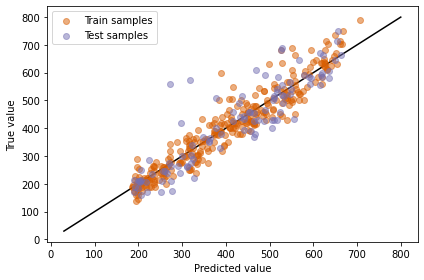

In [34]:
plt.scatter(train_predictions, y_train, label="Train samples", c='#d95f02', alpha=0.5)
plt.scatter(test_predictions, y_test, label="Test samples", c='#7570b3', alpha=0.5)
plt.xlabel("Predicted value")
plt.ylabel("True value")
plt.legend()
plt.plot([30, 800], [30, 800], c='k', zorder=0)
#plt.xlim([30, 400])
#plt.ylim([30, 400])
plt.tight_layout()
plt.show()

In [53]:
with open('out/automl21.pickle', 'wb') as handle:
    pickle.dump([automl, X_train, X_test, y_train, y_test], handle, protocol=pickle.HIGHEST_PROTOCOL)

# Apply on full plot

In [37]:
uav_measured.replace([np.inf, -np.inf], np.nan, inplace=True)
uav_measured = uav_measured.dropna()
uav_measured

,date,field,label,pos,area(mm2),convex_area(mm2),eccentricity,equivalent_diameter(mm),major_axis_length(mm),minor_axis_length(mm),perimeter(mm),circularity
0,20210512,24-2,285,West,2371,2529,0.485232,54.944071,59.213990,51.775862,197.438600,0.764324
1,20210514,24-2,285,West,4424,4565,0.438728,75.052060,79.395531,71.346405,260.350288,0.820179
2,20210515,24-2,285,West,5680,5766,0.314625,85.041170,87.950560,83.484087,291.521861,0.839877
3,20210519,24-2,285,West,12854,13470,0.500925,127.930532,139.130930,120.416505,460.315801,0.762318
4,20210520,24-2,285,West,14110,14488,0.489623,134.035107,144.629077,126.107069,460.658946,0.835560
...,...,...,...,...,...,...,...,...,...,...,...,...
17697,20210526,15-125,1660,West,4380,4698,0.611704,74.677903,84.545288,66.882632,284.971609,0.677768
17698,20210526,12-66,2015,East,4128,4778,0.895483,72.497813,117.143445,52.140058,314.699531,0.523790
17699,20210526,4-21,3082,East,9414,10683,0.893977,109.481857,170.052081,76.202503,446.931024,0.592247
17700,20210526,1-33,3513,East,4057,5397,0.942323,71.871641,137.165555,45.910162,340.693434,0.439225


In [39]:
X_full = uav_measured.copy().drop(columns=["date", "field", "label", "pos"]).to_numpy()
X_full

array([[2.37100000e+03, 2.52900000e+03, 4.85231653e-01, ...,
        5.17758621e+01, 1.97438600e+02, 7.64323639e-01],
       [4.42400000e+03, 4.56500000e+03, 4.38728002e-01, ...,
        7.13464049e+01, 2.60350288e+02, 8.20179398e-01],
       [5.68000000e+03, 5.76600000e+03, 3.14624881e-01, ...,
        8.34840867e+01, 2.91521861e+02, 8.39877493e-01],
       ...,
       [9.41400000e+03, 1.06830000e+04, 8.93977056e-01, ...,
        7.62025034e+01, 4.46931024e+02, 5.92247250e-01],
       [4.05700000e+03, 5.39700000e+03, 9.42322535e-01, ...,
        4.59101617e+01, 3.40693434e+02, 4.39225296e-01],
       [1.46220000e+04, 2.30870000e+04, 8.67280571e-01, ...,
        1.20604303e+02, 6.93884343e+02, 3.81629965e-01]])

In [40]:
X_full.shape

(17696, 8)

In [41]:
W_predict = automl.predict(X_full)

In [47]:
import seaborn as sns

<AxesSubplot:ylabel='Density'>

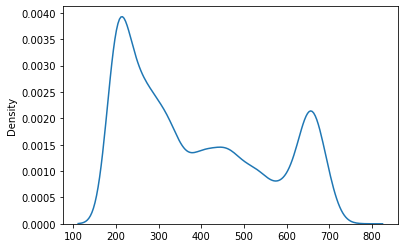

In [48]:
sns.kdeplot(x=W_predict)

In [49]:
uav_measured["weight_pred"] = W_predict
uav_measured

/tmp/ipykernel_779/3352450077.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uav_measured["weight_pred"] = W_predict


,date,field,label,pos,area(mm2),convex_area(mm2),eccentricity,equivalent_diameter(mm),major_axis_length(mm),minor_axis_length(mm),perimeter(mm),circularity,weight_pred
0,20210512,24-2,285,West,2371,2529,0.485232,54.944071,59.213990,51.775862,197.438600,0.764324,197.052837
1,20210514,24-2,285,West,4424,4565,0.438728,75.052060,79.395531,71.346405,260.350288,0.820179,202.735885
2,20210515,24-2,285,West,5680,5766,0.314625,85.041170,87.950560,83.484087,291.521861,0.839877,243.152681
3,20210519,24-2,285,West,12854,13470,0.500925,127.930532,139.130930,120.416505,460.315801,0.762318,382.043412
4,20210520,24-2,285,West,14110,14488,0.489623,134.035107,144.629077,126.107069,460.658946,0.835560,391.628052
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17697,20210526,15-125,1660,West,4380,4698,0.611704,74.677903,84.545288,66.882632,284.971609,0.677768,233.131654
17698,20210526,12-66,2015,East,4128,4778,0.895483,72.497813,117.143445,52.140058,314.699531,0.523790,302.642498
17699,20210526,4-21,3082,East,9414,10683,0.893977,109.481857,170.052081,76.202503,446.931024,0.592247,482.737647
17700,20210526,1-33,3513,East,4057,5397,0.942323,71.871641,137.165555,45.910162,340.693434,0.439225,423.212924


<AxesSubplot:xlabel='weight_pred', ylabel='Density'>

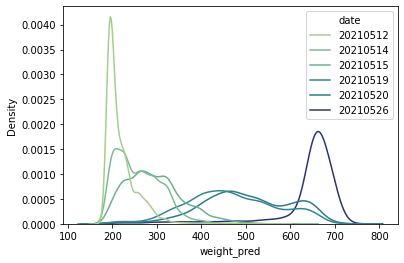

In [51]:
sns.kdeplot(data=uav_measured, x="weight_pred", hue="date", palette="crest")

In [54]:
uav_measured.to_excel("out/2021_measured_weight.xlsx", index=False)